In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_301939/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)


In [3]:
def take_rmse_average_at_level_and_variable(level_in_speedy,variable_speedy):
    # Define: Initial FILES, dates, Variable, and Level desired

    analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'
    
    analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_original_weights_20110101_20120101/mean_output/out.nc'
    
    anal_era5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_1_3_6hr_timestep_1_24_24_20110101_20120101/mean_output/out.nc'
    
    ######HYBRID 1.9,1.9,1.3
    hybrid_2nd_iter_anal_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_1_3_20110101_20110830/mean_output/out.nc'#'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_1_3_original_weights_mem1fixed_20110101_20120501/mean_output/out.nc'
    
    hybrid_1_9_1_3_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_3_mem1_fixed_20110101_20120501/mean_output/analysis_mean_20110101_20120501.nc'
    
    speedy_1_9_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_1_9_uniform_20110101_20110501/mean.nc'
    
    hybrid_1_9_1_9_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_mem_1_fixed_20110101_20120115/out.nc'
    
    hybrid_1_9_2_2_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_2_2_mem1fixed_20110101_20110301/mean_output/out.nc'
    
    hybrid_1_9_1_5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_5_mem1fixed_20110101_20110301/mean_output/out.nc'
    
    speedy_2_2_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_2_2_20110101_20110301/mean_output/out.nc'
    
    speedy_1_5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40_member_speedy_covar1_5_20110101_20120901/mean.nc'
    
    era_5_1_9_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_1_9/mean_output/out.nc'
    
    era_5_2_2_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA_trained_hybrid_2_2/mean_output/out.nc'

    # NEW 2nd iteration
    
    hybrid_1_9_1_9_1_9_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_1_9_2nd_inter_20110101_20110924/mean_output/out.nc'
    
    hybrid_1_9_1_9_1_5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_1_5_20110101_20120101/mean_output/out.nc'
    
    hybrid_1_9_1_9_1_7_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_1_7_20110101_20120101/mean_output/out.nc'
    
    start_year = 2011
    end_year = 2011

    startdate = datetime(2011,1,1,0)
    enddate = datetime(2011,3,1,0)
    time_slice = slice(startdate,enddate)

    #level = 0.95 #0.2#0.95#0.51
    #level_era = 7 #2#7 #4

    level = level_in_speedy
    if level_in_speedy == .95:
        level_in_era = 7
    if level_in_speedy == .835:
        level_in_era = 6
    if level_in_speedy == .685:
        level_in_era = 5
    if level_in_speedy == .51:
        level_in_era = 4
    if level_in_speedy == .34:
        level_in_era = 3
    if level_in_speedy == .2:
        level_in_era = 2
    if level_in_speedy == .095:
        level_in_era = 1
    if level_in_speedy == .025:
        level_in_era = 0
#     print(level_in_era)    
    level_era = level_in_era

    var_da = variable_speedy
    
    
    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
#     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    timestep_6hrly = 6


    # create empty list to store indiviudal datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')

    # loop over the range of years and open each ds
    for year in range(start_year, end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        # only load var_era selected and only load level_era selected from above
        ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
        # Read in every 6th timestep
        ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
        era5sets.append(ds_nature)

    print('Now its concatinating them all together...')

    ds_nature = xr.concat(era5sets, dim = 'Timestep')
    ds_nature = ds_nature.sortby('Timestep')
    print('Done concat and sortby Timestep...')
    temp_500_nature = ds_nature.values

    ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
    ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

    # add ERA5
    ds_era5trained_anal_mean = xr.open_dataset(anal_era5_file)[var_da].sel(lev=level,time=time_slice)
    
    #2nd iter
    ds_2nditer_hybrid = xr.open_dataset(hybrid_2nd_iter_anal_file)[var_da].sel(lev=level,time=time_slice)
    
    # hybrid 1.9,1.3
    ds_hybrid_1_9_1_3 = xr.open_dataset(hybrid_1_9_1_3_file)[var_da].sel(lev=level,time=time_slice)
    
    # speedy 1_9
    ds_speedy_1_9 = xr.open_dataset(speedy_1_9_file)[var_da].sel(lev=level,time=time_slice)
    
    # hybrid 1.9, 1.9 
    ds_hybrid_1_9_1_9 = xr.open_dataset(hybrid_1_9_1_9_file)[var_da].sel(lev=level,time=time_slice)
    
    # hybrid 1.9, 2.2
    ds_hybrid_1_9_2_2 = xr.open_dataset(hybrid_1_9_2_2_file)[var_da].sel(lev=level,time=time_slice)
    
    # hybrid 1.9, 1.5 
    ds_hybrid_1_9_1_5 = xr.open_dataset(hybrid_1_9_1_5_file)[var_da].sel(lev=level,time=time_slice)
    
    # BOOM NEWIES
    
    # speedy 1.5
    ds_speedy_1_5 = xr.open_dataset(speedy_1_5_file)[var_da].sel(lev=level,time=time_slice)
    
    # speedy 2.2
    ds_speedy_2_2 = xr.open_dataset(speedy_2_2_file)[var_da].sel(lev=level,time=time_slice)
    
    # ERA5 1.9
    ds_era5_1_9 = xr.open_dataset(era_5_1_9_file)[var_da].sel(lev=level,time=time_slice)
    
    #ERA5 2.2 
    ds_era5_2_2 = xr.open_dataset(era_5_2_2_file)[var_da].sel(lev=level,time=time_slice)
    
    # Hybrid 1.9,1.9,1.9
    ds_hybrid_1_9_1_9_1_9 = xr.open_dataset(hybrid_1_9_1_9_1_9_file)[var_da].sel(lev=level,time=time_slice)
    
    # 2nd iteration tests here
    ds_hybrid_1_9_1_9_1_5 = xr.open_dataset(hybrid_1_9_1_9_1_5_file)[var_da].sel(lev=level,time=time_slice)
    ds_hybrid_1_9_1_9_1_7 = xr.open_dataset(hybrid_1_9_1_9_1_7_file)[var_da].sel(lev=level,time=time_slice)
    
    temp_500_analysis = ds_analysis_mean

    # temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
    temp_500_analysis_speedy = ds_analysis_mean_speedy
    # temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
    # temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
    # temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values

    print('era5 shape = ',np.shape(temp_500_nature))
    print('speedy shape = ',np.shape(temp_500_analysis_speedy))
    print('hybrid shape = ',np.shape(temp_500_analysis))

    # find smallest index value to set that as the "length"
    speedy_index = temp_500_analysis_speedy.shape[0]
    nature_index = temp_500_nature.shape[0]
    hybrid_index = temp_500_analysis.shape[0]
    hybrid_2ndindex = ds_2nditer_hybrid.shape[0]
    
    smallest_index = min(speedy_index,nature_index,hybrid_index,hybrid_2ndindex)

    if smallest_index == speedy_index:
        length = speedy_index #- 1
    elif smallest_index == nature_index:
        length = nature_index
    elif smallest_index == hybrid_index:
        length = hybrid_index
    else:
        length = hybrid_2ndindex
        
    print('the smallest length is',length)

    #ps_nature = ds_nature['logp'].values
    #ps_nature = 1000.0 * np.exp(ps_nature)
    #ps_analysis = ds_analysis_mean['ps'].values/100.0

    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    analysis_rmse = np.zeros((length))
    analysis_rmse_speedy = np.zeros((length))
    # global_average_ensemble_spread_hybrid = np.zeros((length))
    # global_average_ensemble_spread_speedy = np.zeros((length))
    #ps_rmse = np.zeros((length))
    anal_rmse_era5trained = np.zeros((length))
    anal_rmse_hybrid_2nd_iter = np.zeros((length))
    anal_rmse_hybrid_1_9_1_3 = np.zeros((length))
    anal_rmse_speedy_1_9 = np.zeros((length))
    anal_rmse_hybrid_1_9_1_9 = np.zeros((length))
    anal_rmse_hybrid_1_9_2_2 = np.zeros((length))
    anal_rmse_hybrid_1_9_1_5 = np.zeros((length))
    anal_rmse_speedy_1_5 = np.zeros((length))
    anal_rmse_speedy_2_2 = np.zeros((length))
    anal_rmse_era5_1_9 = np.zeros((length))
    anal_rmse_era5_2_2 = np.zeros((length))
    anal_rmse_hybrid_1_9_1_9_1_9 = np.zeros((length))
    anal_rmse_hybrid_1_9_1_9_1_5 = np.zeros((length))
    anal_rmse_hybrid_1_9_1_9_1_7 = np.zeros((length))
    
    analysis_error = np.zeros((length,ygrid,xgrid))
    analysis_error_speedy = np.zeros((length,ygrid,xgrid))

    print(np.shape(analysis_error))
    print(np.shape(analysis_error_speedy))

    print('Now its calculating analysis RMSE...')
    lats = ds_nature.Lat
    for i in range(length):
        analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
        analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        anal_rmse_era5trained[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_era5trained_anal_mean[i,:,:],lats)
        anal_rmse_hybrid_2nd_iter[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_2nditer_hybrid[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_3[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_3[i,:,:],lats)
        anal_rmse_speedy_1_9[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_speedy_1_9[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_9[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_9[i,:,:],lats)
        anal_rmse_hybrid_1_9_2_2[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_2_2[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_5[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_5[i,:,:],lats)
        anal_rmse_speedy_1_5[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_speedy_1_5[i,:,:],lats)
        anal_rmse_speedy_2_2[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_speedy_2_2[i,:,:],lats)
        anal_rmse_era5_1_9[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_era5_1_9[i,:,:],lats)
        anal_rmse_era5_2_2[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_era5_2_2[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_9_1_9[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_9_1_9[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_9_1_9[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_9_1_9[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_9_1_5[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_9_1_5[i,:,:],lats)
        anal_rmse_hybrid_1_9_1_9_1_7[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_hybrid_1_9_1_9_1_7[i,:,:],lats)
        
        #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
#         analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
#         analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
    #     global_average_ensemble_spread_hybrid[i] = np.average(temp_500_spread_hybrid[i,:,:])
    #     global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])

    # print('mean analysis_rmse = ',analysis_rmse)

    print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP')
    ## MAKING AVERAGES
    
    global average_hybrid
    average_hybrid = np.average(analysis_rmse)
    print('average Hybrid ', average_hybrid)
    
    global average_hybrid2iter
    average_hybrid2iter = np.average(anal_rmse_hybrid_2nd_iter)
    print('average hybrid 2nditer', average_hybrid2iter)
    
    global average_speedy
    average_speedy = np.average(analysis_rmse_speedy)
    print('average speedy ', average_speedy)
    
    global average_era5trained
    average_era5trained = np.average(anal_rmse_era5trained)
    print('average_era5trained ', average_era5trained)
    
    global average_hybrid_1_9_1_3
    average_hybrid_1_9_1_3 = np.average(anal_rmse_hybrid_1_9_1_3)
    print('average_hybrid_1_9_1_3', average_hybrid_1_9_1_3)
    
    global average_speedy_1_9
    average_speedy_1_9 = np.average(anal_rmse_speedy_1_9)
    print('average_speedy_1_9', average_speedy_1_9)
    
    global average_hybrid_1_9_1_9
    average_hybrid_1_9_1_9 = np.average(anal_rmse_hybrid_1_9_1_9)
    print('average_hybrid_1_9_1_9', average_hybrid_1_9_1_9)
    
    global average_hybrid_1_9_2_2
    average_hybrid_1_9_2_2 = np.average(anal_rmse_hybrid_1_9_2_2)
    print('average_hybrid_1_9_2_2', average_hybrid_1_9_2_2)
    
    global average_hybrid_1_9_1_5
    average_hybrid_1_9_1_5 = np.average(anal_rmse_hybrid_1_9_1_5)
    print('average_hybrid_1_9_1_5', average_hybrid_1_9_1_5)
    
    global average_speedy_1_5
    average_speedy_1_5 = np.average(anal_rmse_speedy_1_5)
    print('average_speedy_1_5', average_speedy_1_5)
    
    global average_speedy_2_2
    average_speedy_2_2 = np.average(anal_rmse_speedy_2_2)
    print('average_speedy_1_5', average_speedy_2_2)
    
    global average_era5_1_9
    average_era5_1_9 = np.average(anal_rmse_era5_1_9)
    print('average_speedy_1_5', average_era5_1_9)
    
    global average_era5_2_2
    average_era5_2_2 = np.average(anal_rmse_era5_2_2)
    print('average_era5_2_2', average_era5_2_2)
    
    #new
    
    global average_hybrid_1_9_1_9_1_9
    average_hybrid_1_9_1_9_1_9 = np.average(anal_rmse_hybrid_1_9_1_9_1_9)
    print('average_hybrid_1_9_1_9_1_9', average_hybrid_1_9_1_9_1_9)
    
    global average_hybrid_1_9_1_9_1_5
    average_hybrid_1_9_1_9_1_5 = np.average(anal_rmse_hybrid_1_9_1_9_1_5)
    print('average_hybrid_1_9_1_9_1_5', average_hybrid_1_9_1_9_1_5)
    
    global average_hybrid_1_9_1_9_1_7
    average_hybrid_1_9_1_9_1_7 = np.average(anal_rmse_hybrid_1_9_1_9_1_7)
    print('average_hybrid_1_9_1_9_1_7', average_hybrid_1_9_1_9_1_7)
    
    print('Done with analysis.')    

In [4]:
# testing

speedy_file_type_list_of_levels = [0.95, 0.835, 0.685, 0.51, 0.34 , 0.2, 0.095, 0.025]
# variable_list_speedy = ['q','u','t','v']
variable_list_speedy = ['q','t','v']

average_list_hybrid_q = []    
average_list_speedy_q = []
average_list_hybrid_v = []
average_list_speedy_v = []
average_list_hybrid_t = []    
average_list_speedy_t = []
average_list_hybrid_u = []
average_list_speedy_u = []
average_list_era5trained_q = []
average_list_era5trained_v = []
average_list_era5trained_t = []
average_list_era5trained_u = []
average_list_hybrid_2nditer_q = []
average_list_hybrid_2nditer_v = []
average_list_hybrid_2nditer_t = []
average_list_hybrid_2nditer_u = []
average_list_hybrid_1_9_1_3_q = []
average_list_hybrid_1_9_1_3_v = []
average_list_hybrid_1_9_1_3_t = []
average_list_hybrid_1_9_1_3_u = []

average_list_speedy_1_9_q = []
average_list_speedy_1_9_v = []
average_list_speedy_1_9_u = []
average_list_speedy_1_9_t = []

average_list_hybrid_1_9_1_9_q = []
average_list_hybrid_1_9_1_9_v = []
average_list_hybrid_1_9_1_9_t = []
average_list_hybrid_1_9_1_9_u = []

average_list_hybrid_1_9_2_2_q = []
average_list_hybrid_1_9_2_2_v = []
average_list_hybrid_1_9_2_2_t = []
average_list_hybrid_1_9_2_2_u = []

average_list_hybrid_1_9_1_5_q = []
average_list_hybrid_1_9_1_5_v = []
average_list_hybrid_1_9_1_5_t = []
average_list_hybrid_1_9_1_5_u = []

average_list_speedy_1_5_q = []
average_list_speedy_1_5_v = []
average_list_speedy_1_5_u = []
average_list_speedy_1_5_t = []

average_list_speedy_2_2_q = []
average_list_speedy_2_2_v = []
average_list_speedy_2_2_u = []
average_list_speedy_2_2_t = []

average_list_era5_1_9_q = []
average_list_era5_1_9_v = []
average_list_era5_1_9_u = []
average_list_era5_1_9_t = []

average_list_era5_2_2_q = []
average_list_era5_2_2_v = []
average_list_era5_2_2_u = []
average_list_era5_2_2_t = []

#new
average_list_hybrid_1_9_1_9_1_9_q = []
average_list_hybrid_1_9_1_9_1_9_v = []
average_list_hybrid_1_9_1_9_1_9_u = []
average_list_hybrid_1_9_1_9_1_9_t = []

# 2nd iter 1.9,1.9, ( 1.7 / 1.5 )
average_list_hybrid_1_9_1_9_1_5_q = []
average_list_hybrid_1_9_1_9_1_5_v = []
average_list_hybrid_1_9_1_9_1_5_u = []
average_list_hybrid_1_9_1_9_1_5_t = []

average_list_hybrid_1_9_1_9_1_7_q = []
average_list_hybrid_1_9_1_9_1_7_v = []
average_list_hybrid_1_9_1_9_1_7_u = []
average_list_hybrid_1_9_1_9_1_7_t = []


# loop
for level in speedy_file_type_list_of_levels:
    for variable in variable_list_speedy: 
        take_rmse_average_at_level_and_variable(level,variable)
        
        if variable == 'q':
            average_list_hybrid_q.append(average_hybrid)
            average_list_speedy_q.append(average_speedy)
            average_list_era5trained_q.append(average_era5trained)
            average_list_hybrid_2nditer_q.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_q.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_q.append(average_speedy_1_9)
            average_list_hybrid_1_9_1_9_q.append(average_hybrid_1_9_1_9)
            average_list_hybrid_1_9_2_2_q.append(average_hybrid_1_9_2_2)
            average_list_hybrid_1_9_1_5_q.append(average_hybrid_1_9_1_5)
            average_list_speedy_1_5_q.append(average_speedy_1_5)
            average_list_speedy_2_2_q.append(average_speedy_2_2)
            average_list_era5_1_9_q.append(average_era5_1_9)
            average_list_era5_2_2_q.append(average_era5_2_2)
            average_list_hybrid_1_9_1_9_1_9_q.append(average_hybrid_1_9_1_9_1_9)
            average_list_hybrid_1_9_1_9_1_5_q.append(average_hybrid_1_9_1_9_1_5)
            average_list_hybrid_1_9_1_9_1_7_q.append(average_hybrid_1_9_1_9_1_7)
            
        elif variable == 'u':
            average_list_hybrid_u.append(average_hybrid)
            average_list_speedy_u.append(average_speedy)
            average_list_era5trained_u.append(average_era5trained)
            average_list_hybrid_2nditer_u.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_u.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_u.append(average_speedy_1_9)
            average_list_hybrid_1_9_1_9_u.append(average_hybrid_1_9_1_9)
            average_list_hybrid_1_9_2_2_u.append(average_hybrid_1_9_2_2)
            average_list_hybrid_1_9_1_5_u.append(average_hybrid_1_9_1_5)
            average_list_speedy_1_5_u.append(average_speedy_1_5)
            average_list_speedy_2_2_u.append(average_speedy_2_2)
            average_list_era5_1_9_u.append(average_era5_1_9)
            average_list_era5_2_2_u.append(average_era5_2_2)
            average_list_hybrid_1_9_1_9_1_9_u.append(average_hybrid_1_9_1_9_1_9)
            average_list_hybrid_1_9_1_9_1_5_u.append(average_hybrid_1_9_1_9_1_5)
            average_list_hybrid_1_9_1_9_1_7_u.append(average_hybrid_1_9_1_9_1_7)
            
        elif variable == 'v':
            average_list_hybrid_v.append(average_hybrid)
            average_list_speedy_v.append(average_speedy)
            average_list_era5trained_v.append(average_era5trained)
            average_list_hybrid_2nditer_v.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_v.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_v.append(average_speedy_1_9)
            average_list_hybrid_1_9_1_9_v.append(average_hybrid_1_9_1_9)
            average_list_hybrid_1_9_2_2_v.append(average_hybrid_1_9_2_2)
            average_list_hybrid_1_9_1_5_v.append(average_hybrid_1_9_1_5)
            average_list_speedy_1_5_v.append(average_speedy_1_5)
            average_list_speedy_2_2_v.append(average_speedy_2_2)
            average_list_era5_1_9_v.append(average_era5_1_9)
            average_list_era5_2_2_v.append(average_era5_2_2)
            average_list_hybrid_1_9_1_9_1_9_v.append(average_hybrid_1_9_1_9_1_9)
            average_list_hybrid_1_9_1_9_1_5_v.append(average_hybrid_1_9_1_9_1_5)
            average_list_hybrid_1_9_1_9_1_7_v.append(average_hybrid_1_9_1_9_1_7)
            
            
        elif variable == 't':
            average_list_hybrid_t.append(average_hybrid)
            average_list_speedy_t.append(average_speedy)
            average_list_era5trained_t.append(average_era5trained)
            average_list_hybrid_2nditer_t.append(average_hybrid2iter)
            average_list_hybrid_1_9_1_3_t.append(average_hybrid_1_9_1_3)
            average_list_speedy_1_9_t.append(average_speedy_1_9)
            average_list_hybrid_1_9_1_9_t.append(average_hybrid_1_9_1_9)
            average_list_hybrid_1_9_2_2_t.append(average_hybrid_1_9_2_2)
            average_list_hybrid_1_9_1_5_t.append(average_hybrid_1_9_1_5)
            average_list_speedy_1_5_t.append(average_speedy_1_5)
            average_list_speedy_2_2_t.append(average_speedy_2_2)
            average_list_era5_1_9_t.append(average_era5_1_9)
            average_list_era5_2_2_t.append(average_era5_2_2)
            average_list_hybrid_1_9_1_9_1_9_t.append(average_hybrid_1_9_1_9_1_9)
            average_list_hybrid_1_9_1_9_1_5_t.append(average_hybrid_1_9_1_9_1_5)
            average_list_hybrid_1_9_1_9_1_7_t.append(average_hybrid_1_9_1_9_1_7)
            
        
            
        print('average list hybrid_q check:', average_list_hybrid_q)
        print('average list speedy_q check:', average_list_speedy_q)
        print('average list era5_q check:', average_list_era5trained_q)
        print('average list hybrid_2nditer_q check:', average_list_hybrid_2nditer_q)
        print('average list hybrid_1_9_1_3_q check:', average_list_hybrid_1_9_1_3_q)
        print('average list speedy_1_9_q check:', average_list_speedy_1_9_q)
        print('average list hybrid_u check:', average_list_hybrid_u)
        print('average list speedy_u check:', average_list_speedy_u)
        print('average list era5_u check:', average_list_era5trained_u)
        print('average list hybrid_2nditer_u check:', average_list_hybrid_2nditer_u)
        print('average list hybrid_1_9_1_3_u check:', average_list_hybrid_1_9_1_3_u)
        print('average list speedy_1_9_u check:', average_list_speedy_1_9_u)
        print('average list hybrid_v check:', average_list_hybrid_v)
        print('average list speedy_v check:', average_list_speedy_v)
        print('average list era5_v check:', average_list_era5trained_v)
        print('average list hybrid_2nditer_v check:', average_list_hybrid_2nditer_v)
        print('average list hybrid_1_9_1_3_v check:', average_list_hybrid_1_9_1_3_v)
        print('average list speedy_1_9_v check:', average_list_speedy_1_9_v)
        print('average list hybrid_t check:', average_list_hybrid_t)
        print('average list speedy_t check:', average_list_speedy_t)
        print('average list era5_t check:', average_list_era5trained_t)
        print('average list hybrid_2nditer_t check:', average_list_hybrid_2nditer_t)
        print('average list hybrid_1_9_1_3_t check:', average_list_hybrid_1_9_1_3_t)
        print('average list speedy_1_9_t check:', average_list_speedy_1_9_t)
        print('average list speedy_1_5_t check:', average_list_speedy_1_5_t)
        print('average list ERA5_2_2_t check:', average_list_era5_2_2_t)
        print('NEWIES CHECK YO')
        print('average list hybrid_1_9_1_9_1_9_t check:', average_list_hybrid_1_9_1_9_1_9_t)
            
print('Vertical profile of era5trained hybrid q ', average_list_era5trained_q)
    

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  0.0013161221197865243
average hybrid 2nditer 0.001352376878784207
average speedy  0.0014114929726622401
average_era5trained  0.0007091538368071968
average_hybrid_1_9_1_3 0.0012853461364873602
average_speedy_1_9 0.001296412157000903
average_hybrid_1_9_1_9 0.0013156632631466988
average_hybrid_1_9_2_2 0.0013418045348806095
average_hybrid_1_9_1_5 0.0012666441859748166
average_speedy_1_5 0.0013334805544717276
average_speedy_1_5 0.0013023009337091874
average_speedy_1_5 0.0007498590489318948
average_era5_2_2 0.0007741676559003722
average_hybri

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.6597891839747692
average hybrid 2nditer 1.5479554868448635
average speedy  1.8636584518327994
average_era5trained  1.1446130230456968
average_hybrid_1_9_1_3 1.5547363139406036
average_speedy_1_9 1.5333945303526608
average_hybrid_1_9_1_9 1.4461121146688984
average_hybrid_1_9_2_2 1.4530434075287122
average_hybrid_1_9_1_5 1.4772323465548487
average_speedy_1_5 1.659261360450133
average_speedy_1_5 1.5096767371213888
average_speedy_1_5 1.0926797475492904
average_era5_2_2 1.0976925595400202
average_hybrid_1_9_1_9_1_9 1.4758269806954427
average_hybrid_1_9_1_9_1_5 1.483784820460066
average_hybrid_1_9_1_9_1_7 1.4690315507132292
Done with analysis.
average list hybrid_q check: [0.0013161221197865243, 0.00139

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.2971973665655916
average hybrid 2nditer 1.2930518579885426
average speedy  1.4533510922379635
average_era5trained  1.024578440792953
average_hybrid_1_9_1_3 1.261721504891472
average_speedy_1_9 1.1887410869075277
average_hybrid_1_9_1_9 1.189813147114299
average_hybrid_1_9_2_2 1.211115730462698
average_hybrid_1_9_1_5 1.1953656331396305
average_speedy_1_5 1.2672388503320107
average_speedy_1_5 1.1944141634405916
average_speedy_1_5 0.9682390196916926
average_era5_2_2 0.9718385358902976
average_hybrid_1_9_1_9_1_9 1.2245948686881407
average_hybrid_1_9_1_9_1_5 1.2315458617632902
average_hybrid_1_9_1_9_1_7 1.2188833710513538
Done with analysis.
average list hybrid_q check: [0.0013161221197865243, 0.0013918

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.326687237381432
average hybrid 2nditer 1.2968894922280614
average speedy  1.548100540909586
average_era5trained  1.0573341024072864
average_hybrid_1_9_1_3 1.2793540642734318
average_speedy_1_9 1.2192341396074255
average_hybrid_1_9_1_9 1.1878345193742197
average_hybrid_1_9_2_2 1.2028078555054806
average_hybrid_1_9_1_5 1.200517606634631
average_speedy_1_5 1.3212695338052034
average_speedy_1_5 1.21578113640411
average_speedy_1_5 0.9941229634144135
average_era5_2_2 0.9981225542881318
average_hybrid_1_9_1_9_1_9 1.2154891546265485
average_hybrid_1_9_1_9_1_5 1.2300279517716999
average_hybrid_1_9_1_9_1_7 1.2141065486875768
Done with analysis.
average list hybrid_q check: [0.0013161221197865243, 0.00139186

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.4713235283702737
average hybrid 2nditer 1.3400220679834423
average speedy  1.7902572577512716
average_era5trained  1.0640402338172816
average_hybrid_1_9_1_3 1.3691077222300985
average_speedy_1_9 1.3741034641547545
average_hybrid_1_9_1_9 1.24724194621235
average_hybrid_1_9_2_2 1.2516456943021042
average_hybrid_1_9_1_5 1.2762002965066
average_speedy_1_5 1.5156407275783361
average_speedy_1_5 1.3497446715077268
average_speedy_1_5 1.0234839118985688
average_era5_2_2 1.0249201449160839
average_hybrid_1_9_1_9_1_9 1.2487560676622995
average_hybrid_1_9_1_9_1_5 1.2677078116292189
average_hybrid_1_9_1_9_1_7 1.2476390665593529
Done with analysis.
average list hybrid_q check: [0.0013161221197865243, 0.00139186

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  4.225937529078504e-05
average hybrid 2nditer 4.486157359306815e-05
average speedy  5.033642742763183e-05
average_era5trained  1.0398370806628324e-05
average_hybrid_1_9_1_3 4.22584667477908e-05
average_speedy_1_9 4.341224128837729e-05
average_hybrid_1_9_1_9 4.417482221792334e-05
average_hybrid_1_9_2_2 4.495149168857857e-05
average_hybrid_1_9_1_5 4.2665261362766735e-05
average_speedy_1_5 4.567766985092174e-05
average_speedy_1_5 4.361598394289986e-05
average_speedy_1_5 1.1110823235660202e-05
average_era5_2_2 1.1073389991772565e-05
average_hybrid_1_9_1_9_1_9 4.6271405245775736e-05
average_hybrid_1_9_1_9_1_5 4.501662598439013e-05
average_hybrid_1_9_1_9_1_7 4.547473000775618e-05
Done with analysis.
averag

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  3.6492772625468453
average hybrid 2nditer 3.507554431504841
average speedy  4.463995691090194
average_era5trained  3.2061205141655003
average_hybrid_1_9_1_3 3.59086830706536
average_speedy_1_9 3.5634314480713147
average_hybrid_1_9_1_9 3.1243369669853887
average_hybrid_1_9_2_2 3.1263452582218476
average_hybrid_1_9_1_5 3.285067980802512
average_speedy_1_5 3.889353674675342
average_speedy_1_5 3.5193934319894526
average_speedy_1_5 2.9714272253623997
average_era5_2_2 2.9771563946446284
average_hybrid_1_9_1_9_1_9 3.085360444547758
average_hybrid_1_9_1_9_1_5 3.2259872241362237
average_hybrid_1_9_1_9_1_7 3.126745185771572
Done with analysis.
average list hybrid_q check: [0.0013161221197865243, 0.00139186054

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.6242923153100637
average hybrid 2nditer 1.407825827095579
average speedy  1.8964094532189992
average_era5trained  1.1078083432173427
average_hybrid_1_9_1_3 1.4944255502918098
average_speedy_1_9 1.485412002112795
average_hybrid_1_9_1_9 1.2717233916375204
average_hybrid_1_9_2_2 1.257387348368198
average_hybrid_1_9_1_5 1.3674253723289393
average_speedy_1_5 1.6708864059126327
average_speedy_1_5 1.4318946006428843
average_speedy_1_5 1.0184590632905437
average_era5_2_2 0.9819262264147086
average_hybrid_1_9_1_9_1_9 1.2247248259274768
average_hybrid_1_9_1_9_1_5 1.2930824731472674
average_hybrid_1_9_1_9_1_7 1.2442465779147571
Done with analysis.
average list hybrid_q check: [0.0013161221197865243, 0.001391

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.8494414913021128e-06
average hybrid 2nditer 1.8494414913021128e-06
average speedy  1.8494414913021128e-06
average_era5trained  2.519843471172824e-07
average_hybrid_1_9_1_3 1.8494414913021128e-06
average_speedy_1_9 1.8494414913021128e-06
average_hybrid_1_9_1_9 1.8494414913021128e-06
average_hybrid_1_9_2_2 1.8494414913021128e-06
average_hybrid_1_9_1_5 1.8494414913021128e-06
average_speedy_1_5 1.8494414913021128e-06
average_speedy_1_5 1.8494414913021128e-06
average_speedy_1_5 3.7289739366852444e-07
average_era5_2_2 3.6744175480239756e-07
average_hybrid_1_9_1_9_1_9 1.8494414913021128e-06
average_hybrid_1_9_1_9_1_5 1.8494414913021128e-06
average_hybrid_1_9_1_9_1_7 1.8494414913021128e-06
Done with analy

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (237, 48, 96)
hybrid shape =  (237, 48, 96)
the smallest length is 237
(237, 48, 96)
(237, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  3.150340741193747
average hybrid 2nditer 3.1827232877916423
average speedy  3.552810817831176
average_era5trained  2.73037100592746
average_hybrid_1_9_1_3 3.2224240574655654
average_speedy_1_9 3.264609467631151
average_hybrid_1_9_1_9 2.913100782828995
average_hybrid_1_9_2_2 2.9192166348549886
average_hybrid_1_9_1_5 3.02759802492359
average_speedy_1_5 3.337346519598981
average_speedy_1_5 3.2623764563210402
average_speedy_1_5 3.0865608881294477
average_era5_2_2 3.0486502089077914
average_hybrid_1_9_1_9_1_9 2.9299331506093345
average_hybrid_1_9_1_9_1_5 2.9984777164861622
average_hybrid_1_9_1_9_1_7 2.9436146961485785
Done with analysis.
average list hybrid_q check: [0.0013161221197865243, 0.001391860541

In [5]:
# convert to g/kg
average_list_era5trained_q_g_kg = [i * 1000 for i in average_list_era5trained_q]
average_list_hybrid_q_g_kg = [i * 1000 for i in average_list_hybrid_q]
average_list_speedy_q_g_kg = [i * 1000 for i in average_list_speedy_q]
average_list_hybrid2nditer_q_g_kg = [i * 1000 for i in average_list_hybrid_2nditer_q]
average_list_hybrid_1_9_1_3_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_1_3_q]
average_list_speedy_1_9_q_g_kg = [i * 1000 for i in average_list_speedy_1_9_q]
average_list_hybrid_1_9_1_9_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_1_9_q]
average_list_hybrid_1_9_2_2_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_2_2_q]
average_list_hybrid_1_9_1_5_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_1_3_q]
average_list_speedy_1_5_q_g_kg = [i * 1000 for i in average_list_speedy_1_9_q]
average_list_speedy_2_2_q_g_kg = [i * 1000 for i in average_list_speedy_2_2_q]
average_list_era5_1_9_q_g_kg = [i * 1000 for i in average_list_era5_1_9_q]
average_list_era5_2_2_q_g_kg = [i * 1000 for i in average_list_era5_2_2_q]
average_list_hybrid_1_9_1_9_1_9_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_1_9_1_9_q]
average_list_hybrid_1_9_1_9_1_5_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_1_9_1_5_q]
average_list_hybrid_1_9_1_9_1_7_q_g_kg = [i * 1000 for i in average_list_hybrid_1_9_1_9_1_7_q]
print('Done Converting Q')

Done Converting Q


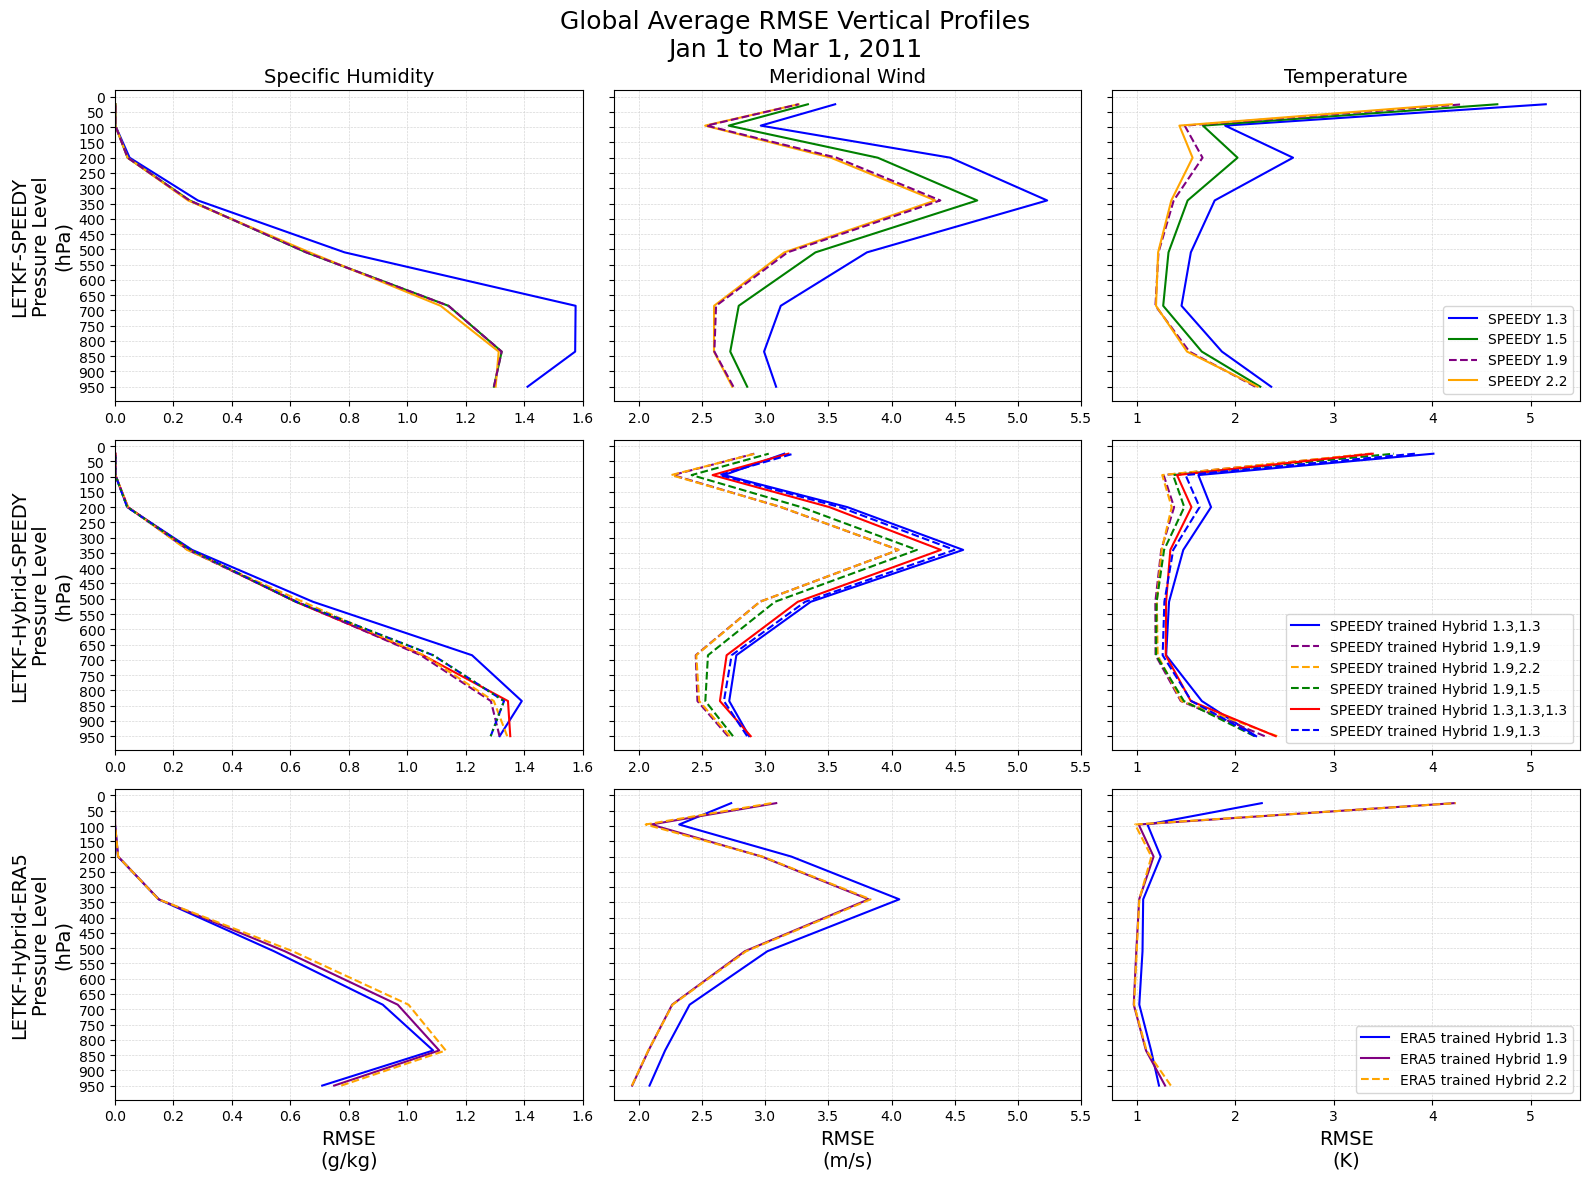

In [6]:
# Assuming speedy_file_type_list_of_levels, average_list_hybrid_q, average_list_hybrid_v, average_list_hybrid_u, and average_list_hybrid_t are defined.

# Create subplots
number_of_rows = 3

number_of_columns = 3

fig, axs = plt.subplots(number_of_columns, number_of_rows, figsize=(16, 12), sharey=True)

# y-axis is height (in hPa)
y_axis = [1000 * i for i in speedy_file_type_list_of_levels]
plt.gca().invert_yaxis()

# Set y-ticks
plt.yticks(np.arange(0, 1000, 50))
i = 0
j = 0
# for i in range(0,4,1):
for j in range(0,number_of_columns):
    while i < number_of_rows:

        axs[i,j].grid(color='lightgrey', linestyle='--', linewidth=0.45)
        i += 1
    # reset i = 0 when exit 1 iteration of loop    
    i = 0
    
fontsize_select = 14 
q_x_min=0
q_x_max=1.6

v_x_min = 1.8
v_x_max = 5.5

t_x_min = .75
t_x_max = 5.5

plt.suptitle('Global Average RMSE Vertical Profiles\nJan 1 to Mar 1, 2011',fontsize=18)

# Plot for 'q'
axs[0,0].plot(average_list_speedy_q_g_kg, y_axis, color='blue')
axs[0,0].plot(average_list_speedy_1_5_q_g_kg, y_axis, color = 'green')
axs[0,0].plot(average_list_speedy_2_2_q_g_kg, y_axis, color = 'orange')
axs[0,0].plot(average_list_speedy_1_9_q_g_kg, y_axis, color = 'purple',linestyle='dashed')
axs[0,0].set_xlim(q_x_min, q_x_max)

axs[1,0].plot(average_list_hybrid_q_g_kg, y_axis, color='blue')
axs[1,0].plot(average_list_hybrid2nditer_q_g_kg, y_axis,color='red')             
axs[1,0].plot(average_list_hybrid_1_9_1_9_q_g_kg,y_axis,color = 'purple',linestyle = 'dashed')
axs[1,0].plot(average_list_hybrid_1_9_2_2_q_g_kg,y_axis,color = 'orange',linestyle = 'dashed')
axs[1,0].plot(average_list_hybrid_1_9_1_3_q_g_kg,y_axis,color = 'blue',linestyle='dashed')
axs[1,0].plot(average_list_hybrid_1_9_1_5_q_g_kg,y_axis,color = 'green',linestyle = 'dotted')
axs[1,0].set_xlim(q_x_min, q_x_max)

axs[2,0].plot(average_list_era5trained_q_g_kg,y_axis,color='blue')
axs[2,0].plot(average_list_era5_1_9_q_g_kg,y_axis,color='purple')
axs[2,0].plot(average_list_era5_2_2_q_g_kg,y_axis,color='orange',linestyle = 'dashed')
axs[2,0].set_xlim(q_x_min, q_x_max)


axs[0,0].set_title('Specific Humidity',fontsize = fontsize_select)
axs[2,0].set_xlabel('RMSE\n(g/kg)',fontsize = fontsize_select)

axs[0,0].set_ylabel('LETKF-SPEEDY\nPressure Level\n(hPa)',fontsize = fontsize_select)
axs[1,0].set_ylabel('LETKF-Hybrid-SPEEDY\nPressure Level\n(hPa)',fontsize = fontsize_select)
axs[2,0].set_ylabel('LETKF-Hybrid-ERA5\nPressure Level\n(hPa)',fontsize = fontsize_select)
# for ax in axs:
#     ax.tick_params(axis='y', labelsize=fontsize_select)  # Set the font size to 12

# Plot for 'v'
axs[0,1].plot(average_list_speedy_v, y_axis, color='blue')
axs[0,1].plot(average_list_speedy_1_5_v, y_axis, color = 'green')
axs[0,1].plot(average_list_speedy_2_2_v, y_axis, color = 'orange')
axs[0,1].plot(average_list_speedy_1_9_v, y_axis, color = 'purple',linestyle='dashed')
axs[0,1].set_xlim(v_x_min, v_x_max)

axs[1,1].plot(average_list_hybrid_v, y_axis, color='blue')
axs[1,1].plot(average_list_hybrid_2nditer_v, y_axis,color='red')
axs[1,1].plot(average_list_hybrid_1_9_1_9_v,y_axis,color = 'purple',linestyle = 'dashed')
axs[1,1].plot(average_list_hybrid_1_9_2_2_v,y_axis,color = 'orange',linestyle = 'dashed')
axs[1,1].plot(average_list_hybrid_1_9_1_5_v,y_axis,color = 'green',linestyle = 'dashed')
axs[1,1].plot(average_list_hybrid_1_9_1_3_v,y_axis,color = 'blue',linestyle='dashed')
axs[1,1].set_xlim(v_x_min, v_x_max)

axs[2,1].plot(average_list_era5trained_v,y_axis,color='blue')
axs[2,1].plot(average_list_era5_1_9_v,y_axis,color='purple')
axs[2,1].plot(average_list_era5_2_2_v,y_axis,color='orange',linestyle = 'dashed')
axs[2,1].set_xlim(v_x_min, v_x_max)

axs[0,1].set_title('Meridional Wind',fontsize = fontsize_select)
axs[2,1].set_xlabel('RMSE\n(m/s)',fontsize = fontsize_select)
# for ax in axs:
#     ax.tick_params(axis='x', labelsize=fontsize_select)
    
    
# # Plot for 'u'
# axs[2].plot(average_list_hybrid_u, y_axis, color='red')
# axs[2].plot(average_list_speedy_u, y_axis, color='blue')
# axs[2].plot(average_list_era5trained_u,y_axis,color='black')
# axs[2].plot(average_list_hybrid_2nditer_u, y_axis,color='green')
# axs[2].plot(average_list_hybrid_1_9_1_3_u,y_axis,color = 'purple')
# axs[2].plot(average_list_speedy_1_9_u, y_axis, color = 'blue', linestyle = 'dashed')
# axs[2].plot(average_list_hybrid_1_9_1_9_u,y_axis,color = 'purple',linestyle = 'dashed')
# axs[2].plot(average_list_hybrid_1_9_2_2_u,y_axis,color = 'orange',linestyle = 'dashed')
# axs[2].plot(average_list_hybrid_1_9_1_5_u,y_axis,color = 'green',linestyle = 'dashed')

# axs[2].set_title('Zonal Wind',fontsize = fontsize_select)
# axs[2].set_xlabel('RMSE\n(m/s)',fontsize = fontsize_select)
# for ax in axs:
#     ax.tick_params(axis='x', labelsize=fontsize_select)



# Plot for 't'
axs[0,2].plot(average_list_speedy_t, y_axis, color='blue', label= 'SPEEDY 1.3')
axs[0,2].plot(average_list_speedy_1_5_t, y_axis, color = 'green',label='SPEEDY 1.5')
axs[0,2].plot(average_list_speedy_1_9_t, y_axis, color = 'purple', linestyle = 'dashed', label='SPEEDY 1.9')
axs[0,2].plot(average_list_speedy_2_2_t, y_axis, color = 'orange',label='SPEEDY 2.2')
axs[0,2].set_xlim(t_x_min, t_x_max)

axs[1,2].plot(average_list_hybrid_t, y_axis, color='blue', label = "SPEEDY trained Hybrid 1.3,1.3")
axs[1,2].plot(average_list_hybrid_1_9_1_9_t,y_axis,color = 'purple',linestyle = 'dashed',label='SPEEDY trained Hybrid 1.9,1.9')
axs[1,2].plot(average_list_hybrid_1_9_2_2_t,y_axis,color = 'orange',linestyle = 'dashed',label='SPEEDY trained Hybrid 1.9,2.2')
axs[1,2].plot(average_list_hybrid_1_9_1_5_t,y_axis,color = 'green',linestyle = 'dashed',label='SPEEDY trained Hybrid 1.9,1.5')
axs[1,2].plot(average_list_hybrid_2nditer_t, y_axis,color='red',label= 'SPEEDY trained Hybrid 1.3,1.3,1.3')
axs[1,2].plot(average_list_hybrid_1_9_1_3_t,y_axis,color = 'blue',linestyle='dashed',label='SPEEDY trained Hybrid 1.9,1.3')
axs[1,2].set_xlim(t_x_min, t_x_max)


axs[2,2].plot(average_list_era5trained_t,y_axis,color='blue',label = "ERA5 trained Hybrid 1.3")
axs[2,2].plot(average_list_era5_1_9_t,y_axis,color='purple',label = "ERA5 trained Hybrid 1.9")
axs[2,2].plot(average_list_era5_2_2_t,y_axis,color='orange',linestyle = 'dashed', label = 'ERA5 trained Hybrid 2.2')
axs[2,2].set_xlim(t_x_min, t_x_max)

for i in range(3):
    axs[i,2].legend() 


# axs[2].plot(average_list_hybrid_t, y_axis, color='red', label = "Speedy trained Hybrid 1.3,1.3")
# axs[2].plot(average_list_hybrid_2nditer_t, y_axis,color='green',label= 'Speedy trained Hybrid 1.3,1.3,1.3 (2nd Iteration)')


# axs[2].plot(average_list_hybrid_1_9_1_3_t,y_axis,color = 'purple',label='Speedy trained Hybrid 1.9,1.3')
# axs[2].plot(average_list_hybrid_1_9_1_9_t,y_axis,color = 'purple',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,1.9')
# axs[2].plot(average_list_hybrid_1_9_2_2_t,y_axis,color = 'orange',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,2.2')
# axs[2].plot(average_list_hybrid_1_9_1_5_t,y_axis,color = 'green',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,1.5')

# axs[2].plot(average_list_speedy_t, y_axis, color='blue', label= 'Speedy 1.3')
# axs[2].plot(average_list_speedy_1_9_t, y_axis, color = 'blue', linestyle = 'dashed', label='Speedy 1.9')

# axs[2].plot(average_list_era5trained_t,y_axis,color='black',label = "ERA5 trained Hybrid 1.3")

axs[0,2].set_title('Temperature',fontsize = fontsize_select)
axs[2,2].set_xlabel('RMSE\n(K)',fontsize = fontsize_select)

# for ax in axs:
#     ax.tick_params(axis='x', labelsize=fontsize_select)

# plt.legend()
# plt.legend(loc='upper center', bbox_to_anchor=(-.60, -0.1), fancybox=True, shadow=True, ncol=0, fontsize = 'large')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
# plt.savefig('Global_RMSE_Vertical_Profiles_5_14_24.png',bbox_inches='tight', dpi=1200)

plt.show()


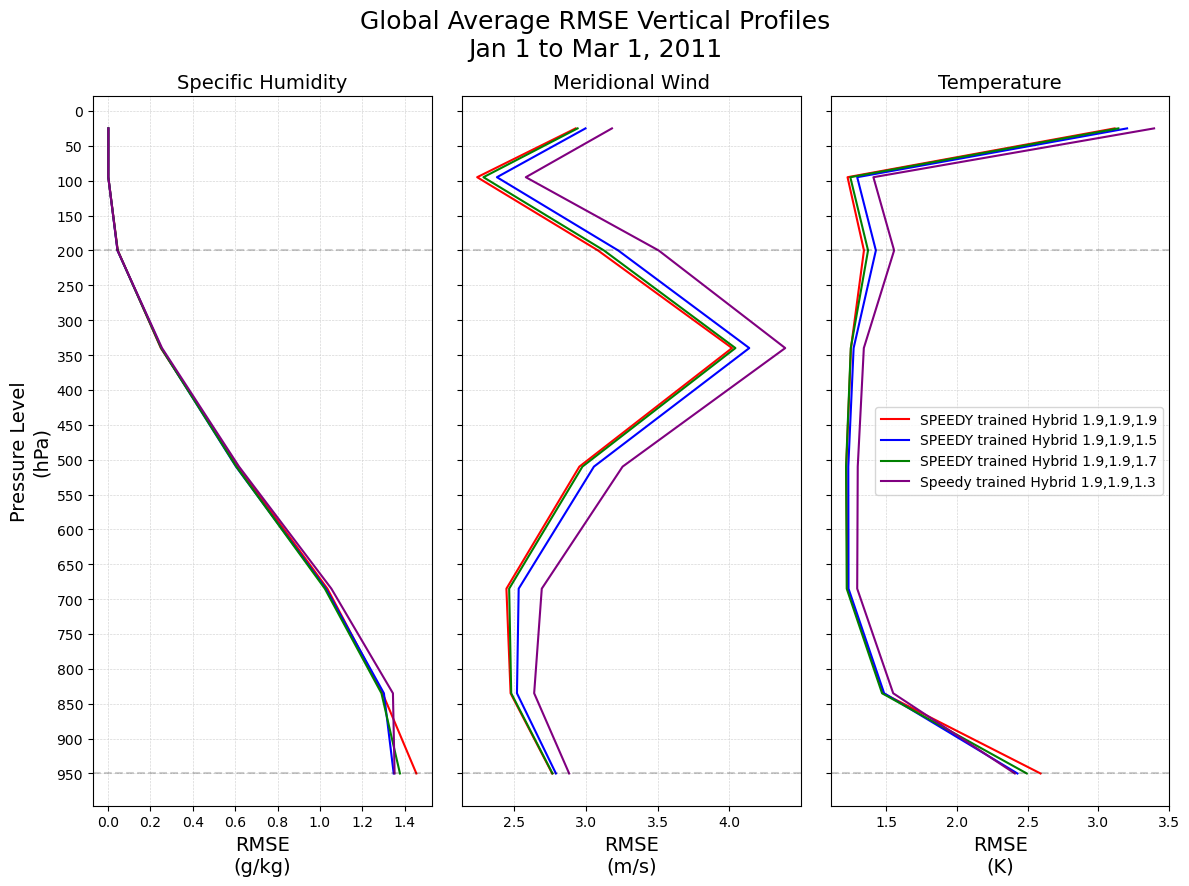

In [7]:
# Assuming speedy_file_type_list_of_levels, average_list_hybrid_q, average_list_hybrid_v, average_list_hybrid_u, and average_list_hybrid_t are defined.

# Create subplots
number_of_columns = 3

number_of_rows = 1

fig, axs = plt.subplots(number_of_rows, number_of_columns, figsize=(12, 9), sharey=True)

# y-axis is height (in hPa)
y_axis = [1000 * i for i in speedy_file_type_list_of_levels]
plt.gca().invert_yaxis()

# Set y-ticks
plt.yticks(np.arange(0, 1000, 50))

i = 0
# for i in range(0,4,1):
while i < number_of_columns:

    axs[i].grid(color='lightgrey', linestyle='--', linewidth=0.45)
    i += 1

    
fontsize_select = 14 
q_x_min=0
q_x_max=1.6

v_x_min = 1.8
v_x_max = 5.5

t_x_min = .75
t_x_max = 5.5

plt.suptitle('Global Average RMSE Vertical Profiles\nJan 1 to Mar 1, 2011',fontsize=18)

# Plot for 'q'
# axs[0,0].plot(average_list_speedy_q_g_kg, y_axis, color='blue')
# axs[0,0].plot(average_list_speedy_1_5_q_g_kg, y_axis, color = 'green')
# axs[0,0].plot(average_list_speedy_2_2_q_g_kg, y_axis, color = 'orange')
# axs[0].plot(average_list_speedy_1_9_q_g_kg, y_axis, color = 'blue')
# axs[0].plot(average_list_speedy_2_2_q_g_kg, y_axis, color = 'orange')
axs[0].plot(average_list_hybrid_1_9_1_9_1_9_q_g_kg,y_axis,color='red')
axs[0].plot(average_list_hybrid_1_9_1_9_1_5_q_g_kg,y_axis,color='blue')
axs[0].plot(average_list_hybrid_1_9_1_9_1_7_q_g_kg,y_axis,color='green')
# axs[0].plot(average_list_hybrid_1_9_1_9_q_g_kg,y_axis,color = 'green',linestyle = 'dashed')

axs[0].plot(average_list_hybrid2nditer_q_g_kg, y_axis,color='purple') # hybrid 1.9,1.9,1.3

# axs[0].plot(average_list_hybrid_1_9_1_5_q_g_kg,y_axis,color = 'green',linestyle = 'dotted')



# axs[0].plot(average_list_era5_1_9_q_g_kg,y_axis,color='black')

# axs[0].set_xlim(q_x_min, q_x_max)


axs[0].set_title('Specific Humidity',fontsize = fontsize_select)
axs[0].set_xlabel('RMSE\n(g/kg)',fontsize = fontsize_select)

axs[0].set_ylabel('Pressure Level\n(hPa)',fontsize = fontsize_select)

# for ax in axs:
#     ax.tick_params(axis='y', labelsize=fontsize_select)  # Set the font size to 12

# Plot for 'v'

# axs[1].plot(average_list_speedy_2_2_v, y_axis, color = 'orange')
# axs[1].plot(average_list_speedy_1_9_v, y_axis, color = 'blue')

axs[1].plot(average_list_hybrid_1_9_1_9_1_9_v,y_axis,color='red')
axs[1].plot(average_list_hybrid_1_9_1_9_1_5_v,y_axis,color='blue')
axs[1].plot(average_list_hybrid_1_9_1_9_1_7_v,y_axis,color='green')
# axs[1].plot(average_list_hybrid_1_9_1_9_v,y_axis,color = 'green',linestyle = 'dashed')

axs[1].plot(average_list_hybrid_2nditer_v, y_axis,color='purple') # hybrid 1.9,1.9,1.3
# axs[1].plot(average_list_hybrid_1_9_1_5_v,y_axis,color = 'green',linestyle = 'dashed')




# axs[1].plot(average_list_era5_1_9_v,y_axis,color='black')

# axs[1].set_xlim(v_x_min, v_x_max)

axs[1].set_title('Meridional Wind',fontsize = fontsize_select)
axs[1].set_xlabel('RMSE\n(m/s)',fontsize = fontsize_select)
# for ax in axs:
#     ax.tick_params(axis='x', labelsize=fontsize_select)
    


# Plot for 't'

# axs[2].plot(average_list_speedy_1_9_t, y_axis, color = 'blue', label='SPEEDY 1.9')
# axs[2].plot(average_list_speedy_2_2_t, y_axis, color = 'orange',label='SPEEDY 2.2')

axs[2].plot(average_list_hybrid_1_9_1_9_1_9_t,y_axis,color='red',label='SPEEDY trained Hybrid 1.9,1.9,1.9')
axs[2].plot(average_list_hybrid_1_9_1_9_1_5_t,y_axis,color='blue',label='SPEEDY trained Hybrid 1.9,1.9,1.5')
axs[2].plot(average_list_hybrid_1_9_1_9_1_7_t,y_axis,color='green',label='SPEEDY trained Hybrid 1.9,1.9,1.7')
# axs[2].plot(average_list_hybrid_1_9_1_9_t,y_axis,color = 'green',linestyle = 'dashed',label='SPEEDY trained Hybrid 1.9,1.9')
# axs[2].plot(average_list_hybrid_1_9_1_5_t,y_axis,color = 'green',linestyle = 'dashed',label='SPEEDY trained Hybrid 1.9,1.5')


# axs[2].plot(average_list_era5_1_9_t,y_axis,color='black',label = "ERA5 trained Hybrid 1.9")

# axs[2].set_xlim(t_x_min, t_x_max)

# for i in range(3):

# axs[2].plot(average_list_hybrid_t, y_axis, color='red', label = "Speedy trained Hybrid 1.3,1.3")
axs[2].plot(average_list_hybrid_2nditer_t, y_axis,color='purple',label= 'Speedy trained Hybrid 1.9,1.9,1.3')
axs[2].legend() 

# axs[2].plot(average_list_hybrid_1_9_1_3_t,y_axis,color = 'purple',label='Speedy trained Hybrid 1.9,1.3')
# axs[2].plot(average_list_hybrid_1_9_1_9_t,y_axis,color = 'purple',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,1.9')
# axs[2].plot(average_list_hybrid_1_9_2_2_t,y_axis,color = 'orange',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,2.2')
# axs[2].plot(average_list_hybrid_1_9_1_5_t,y_axis,color = 'green',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,1.5')

# axs[2].plot(average_list_speedy_t, y_axis, color='blue', label= 'Speedy 1.3')
# axs[2].plot(average_list_speedy_1_9_t, y_axis, color = 'blue', linestyle = 'dashed', label='Speedy 1.9')

# axs[2].plot(average_list_era5trained_t,y_axis,color='black',label = "ERA5 trained Hybrid 1.3")

axs[2].set_title('Temperature',fontsize = fontsize_select)
axs[2].set_xlabel('RMSE\n(K)',fontsize = fontsize_select)

# for ax in axs:
#     ax.tick_params(axis='x', labelsize=fontsize_select)
# Adding horizontal line
highlight_list = [950,200]
for height in highlight_list:    
    for ax in axs:
        ax.axhline(y=height, color='black', linestyle='--',alpha=0.2)


# plt.legend()
# plt.legend(loc='upper center', bbox_to_anchor=(-.60, -0.1), fancybox=True, shadow=True, ncol=0, fontsize = 'large')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.savefig('Global_RMSE_Vertical_Profiles_6_25_24',bbox_inches='tight', dpi=1200)

plt.show()


In [ ]:
print(y_axis)

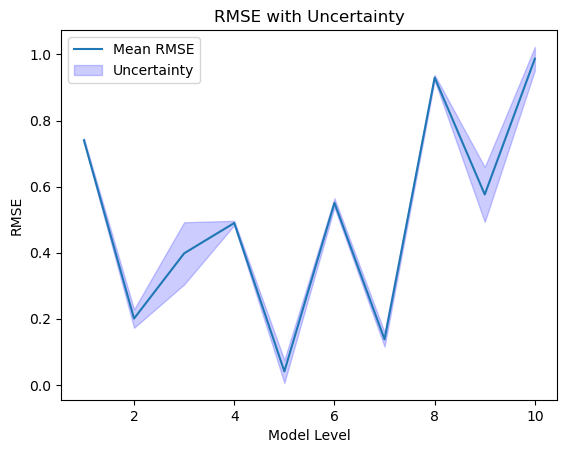

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
levels = np.arange(1, 11)  # levels in the model
mean_rmse = np.random.rand(10)  # mean RMSE at each level
std_rmse = np.random.rand(10) * 0.1  # standard deviation of RMSE at each level

# Plot mean RMSE
plt.plot(levels, mean_rmse, label='Mean RMSE')

# Plot shaded error region
plt.fill_between(levels, mean_rmse - std_rmse, mean_rmse + std_rmse, color='b', alpha=0.2, label='Uncertainty')

# Labels and legend
plt.xlabel('Model Level')
plt.ylabel('RMSE')
plt.title('RMSE with Uncertainty')
plt.legend()

# Show plot
plt.show()
